In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from mesh_tools import trimesh_utils as tu
from datasci_tools import ipyvolume_utils as ipvu
from neurd import neuron_visualizations as nviz
from pathlib import Path

In [4]:
segment_id = 864691135510518224

# Load the appropriate volume data inferface object

In [5]:
from neurd.vdi_microns import volume_data_interface as vdi
#vdi.set_parameters_for_directory_modules()

HTTP request sent; waiting for response./1.1 302 FOUND                      

>

In [6]:
synapse_filepath = str(Path(f'./{segment_id}_synapses.csv').absolute())
synapse_filepath

'/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/864691135510518224_synapses.csv'

In [7]:
from datasci_tools import pandas_utils as pu
df = pu.csv_to_df(synapse_filepath)
df

,prepost,synapse_id,synapse_x,synapse_y,synapse_z,synapse_size,segment_id
0,presyn,483766883,372182,155486,27762,4384,864691135510518224
1,presyn,478550136,371370,156720,27781,2068,864691135510518224
2,presyn,480939462,370330,141276,27795,11064,864691135510518224
3,presyn,479220146,370697,150480,26371,8636,864691135510518224
4,presyn,468794187,363722,154550,27349,3516,864691135510518224
...,...,...,...,...,...,...,...
960,postsyn,483712349,375430,152370,26897,17880,864691135510518224
961,postsyn,492052366,381210,155648,26422,8680,864691135510518224
962,postsyn,486032429,373180,142870,25738,2244,864691135510518224
963,postsyn,477362400,369214,146406,27836,18312,864691135510518224


In [8]:
vdi.set_synapse_filepath(
    synapse_filepath
)

# Data Prep: Loading mesh

In [9]:
mesh = vdi.fetch_segment_id_mesh(
    segment_id,
    plot = True
)
mesh

/usr/local/lib/python3.8/dist-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

<trimesh.Trimesh(vertices.shape=(154713, 3), faces.shape=(323535, 3))>

In [10]:
from datasci_tools import pipeline

products = pipeline.PipelineProducts()
products

# Step 1: Decimation

In [11]:
"""
NOTE: an already decimated mesh is used for the example
in order to speed up time, that's why the mesh_dec
object will be overwritten with original mesh object
"""

"\nNOTE: an already decimated mesh is used for the example\nin order to speed up time, that's why the mesh_dec\nobject will be overwritten with original mesh object\n"

In [12]:
decimation_parameters = dict(
    decimation_ratio =0.25,
)

In [13]:
mesh_decimated = tu.decimate(
    mesh,
    **decimation_parameters
)

xvfb-run -n 8266 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_2866.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_2866_decimated.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/decimation_meshlab_25583622.mls


In [14]:
# saving any parameters used or output products for later use
products.set_stage_attrs(
    stage = "decimation",
    attr_dict = dict(
        decimation_parameters = decimation_parameters,
        segment_id = segment_id,
    ),
    
)

print(products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691135510518224,
  },
}



# Step 2: Soma Identification

In [15]:
from neurd import soma_extraction_utils as sm
soma_extraction_parameters = dict()

In [16]:
# could inspect the parameters of a certain category
from neurd import parameter_utils as paru
paru.category_param_from_module(
        module = sm,
        category = "glia",
)

{'glia_volume_threshold_in_um_global': 2500,
 'glia_n_faces_threshold_global': 400000,
 'glia_n_faces_min_global': 100000}

In [17]:
# overwritting decimated mesh because original was already decimated
mesh_decimated = mesh

# soma_indentification

In [18]:
from neurd import neuron_visualizations as nviz

verbose = True

soma_products = sm.soma_indentification(
    mesh_decimated,
    verbose=verbose,
    **soma_extraction_parameters
)

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 5000.0 
large_mesh_threshold_inner = 3250.0 
soma_size_threshold = 562.5 
soma_size_threshold_max = 75000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
max_mesh_sized_filtered_away = 22500.0
xvfb-run -n 5768 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_45369.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_45369_remove_interior.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/remove_interior_659474.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_45369.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_45369_remove_interior.off
/neurd_packages/NEURD/Applications/Tutorials/Auto_P

  0%|          | 0/9 [00:00<?, ?it/s]

      ------ Found 1 viable somas: [0.769893]
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 6116 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_729604.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_729604_poisson.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_263696.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_729604.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_729604_poisson.off
mesh.is_watertight = True
/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_263696.mls is being deleted....
Inside sphere validater: ratio_va

  0%|          | 0/3 [00:00<?, ?it/s]

      ------ Found 2 viable somas: [0.781901, 0.3351845]
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 4586 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_373859.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_373859_poisson.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_927450.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_373859.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_373859_poisson.off
mesh.is_watertight = True
/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_927450.mls is being deleted....
Inside sphere validate

xvfb-run -n 4499 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_96464.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_96464_fill_holes.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/fill_holes_957733.mls

---- meshlab output -----
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
Current Plugins Dir is: /meshlab/src/distrib/plugins 
Error While parsing the XML filter plugin descriptors: We are trying to load a xml file that does not correspond to any dll or javascript code; please delete all the spurious xml files
Error While parsing the XML filter plugin descriptors: We are trying to load a xml file that does not correspond to any dll or javascript code; please delete all the spurious xml files
Opening a file with extention off
FilterScript
Reading filter with name Remove Duplicate Ve

removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_942007.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_942007_poisson.off
mesh.is_watertight = False
/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_78098.mls is being deleted....
Inside sphere validater: ratio_val = 2.779561458917224
About to add the following inside nuclei pieces after soma backtrack: [<trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>, <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>, <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>, <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>, <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>, <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>, <trimesh.Trimesh(vertice

  0%|          | 0/9 [00:00<?, ?it/s]

Largest hole before segmentation = 84198.44608552229, after = 79686.03659527568,

ratio = 0.9464074493053798, difference = -4512.409490246602
Skipping the segmentatio filter at end
removing mesh interior before segmentation
xvfb-run -n 8857 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_7423.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_7423_fill_holes.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/fill_holes_837030.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_7423.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_7423_fill_holes.off
/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/fill_holes_837030.mls is being deleted....
xv

  0%|          | 0/2 [00:00<?, ?it/s]

No split meshes were above the width threshold (0.32) and size threshold (2000) so continuing
So just going with old somas
filtered_soma_list_components = [<trimesh.Trimesh(vertices.shape=(11386, 3), faces.shape=(22560, 3))>
 <trimesh.Trimesh(vertices.shape=(5708, 3), faces.shape=(10517, 3))>]
Not need to do a second pass because already found a soma


In [19]:
soma_products.soma_run_time

80.59977841377258

In [20]:
sm.plot_soma_products(
    mesh_decimated,
    soma_products = soma_products,
    verbose = True
)

# of somas = 2
# of glia = 0
# of nuclei = 18


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [21]:
products.set_stage_attrs(
    stage = "soma_identification",
    attr_dict = soma_products,
)

print(products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691135510518224,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>, <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>, <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>, <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>, <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>, <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>, <trimesh.Trimesh(vertices.shape=(864, 3), faces.shape=(1989, 3))>, <trimesh.Trimesh(vertices.shape=(723, 3), faces.shape=(1611, 3))>, <trimesh.Trimesh(vertices.shape=(693, 3), faces.shape=(1561, 3))>, <trimesh.Trimesh(vertices.shape=(612, 3), faces.shape=(1378, 3))>, <trimesh.Trimesh(vertices.shape=(456, 3), faces.shape=(742, 3))>, <trimesh.Trimesh(vertices.shape=(344, 3), faces.

# Step 2b: Saving off pipeline products

In [22]:
from datasci_tools import system_utils as su
su.save_object(
    products,"products_up_to_soma_stage"
)

Saved object at /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/products_up_to_soma_stage.pkl
File size is 4.589403 MB
Cleared mesh: <trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>:139864068125984
Cleared mesh: <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>:139864068149360
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>:139864068152192
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>:139864067962576
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>:139864068151856
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>:139864068127328
Cleared mesh: <trimesh.Trimesh(vertices.shape=(864, 3), faces.shape=(1989, 3))>:139863558710368
Cleared mesh: <trimesh.Trimesh(vertices.shape=(723, 3), faces.shape=(1611, 3))>:139863558684976
Cleared mesh: <trimesh.Trimesh(vertices.shape=(693, 3), faces.shape=(1561, 3)

# Step 3: Decomposition

--- 0) Having to preprocess the Neuron becuase no preprocessed data
Please wait this could take a while.....
Skipping the hole filling
limb_remove_mesh_interior_face_threshold = 0
use_meshafterparty = True
Using pre-computed somas: soma_mesh_list = [<trimesh.Trimesh(vertices.shape=(11386, 3), faces.shape=(22560, 3))>, <trimesh.Trimesh(vertices.shape=(5708, 3), faces.shape=(10517, 3))>]
Soma List = [<trimesh.Trimesh(vertices.shape=(11386, 3), faces.shape=(22560, 3))>, <trimesh.Trimesh(vertices.shape=(5708, 3), faces.shape=(10517, 3))>]
soma_mesh_list_centers = [array([1488880.76058317,  589300.09373793, 1100652.31345512]), array([1472182.71408549,  577993.08644009, 1112354.27575333])]
Getting Glia and Nuclei Pieces Subtracted Away 0.16956114768981934
 Splitting mesh after soma cancellation 1.969372272491455
# of split_meshes = 4
 Containing Mesh Indices 0.020421266555786133
containing_mesh_indices = {0: 0, 1: 0}
 non_soma_touching_meshes 3.0040740966796875e-05
There were 3 pieces found 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/33579 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.40282249450683594
connecting at the root
branches_touching_root = [6]
combining close nodes
combine_threshold = 700
length of Graph = 3258
After combining close endpoints max(kept_branches_idx) = 6, len(kept_branches_idx) = 7
empty_indices % = 0.0
 conflict_indices % = 0.002908632942517017


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Decomposing first pass: 2.5997347831726074
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [639, 7663]
mesh_large_connectivity: 0.0022737979888916016
Finding MAP candidates connected components: 9.012222290039062e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.08162093162536621
Grouping MP Sublimbs by Graph: 0.03701305389404297
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0011782646179199219
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 2283 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None_poisson.off -s /neurd_packages/NEURD/Applications/T

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.018645048141479492
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 9.459510087966919
Checking connected components after removing cycles
Total time for mesh KDTree = 0.07180142402648926
sbv[0].reshape(-1,3) = [[1487208.   596715.8 1099876. ]]
closest_sk_pt_coord BEFORE = [1487610.  597308. 1100710.]
current_skeleton.shape = (291, 2, 3)
node_for_stitch = 209: [1487610.  597308. 1100710.]
node_for_stitch AFTER = 209: [1487610.  597308. 1100710.]
possible_node_loc = [  0  48 209 291]
possible_node_loc AFTER = [  0  48 209 291]
curr_shortest_path = [209]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1487610.  597308. 1100710.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1487610.,  597308., 1100

  0%|          | 0/1 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (271, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 9.799775123596191
Working on limb correspondence for #0 MAP piece
xvfb-run -n 1270 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_88200.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_88200_remove_interior.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/remove_interior_863202.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_88200.off
removed temporary output file: /neurd_p

0it [00:00, ?it/s]

Total time for decomposition = 2.42488956451416
mesh_correspondence_first_pass: 2.424941062927246
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (271, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (271, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.15092748735244518
 conflict_indices % = 0.04384485666104553


  0%|          | 0/14 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 12.650143146514893
correspondence_1_to_1: 0.4242842197418213
Total time for MAP sublimb processing 12.650233507156372
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.016069412231445312
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.00995016098022461
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.010073184967041016
Do Not Need to Fix MP Decomposition 2 so just continuing
Successful mesh connectivity with type edges

---- Working on (0, 0) connection-----
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [1491450.08344721  608267.60149996 1098228.13300974]
MP_branches_with_stitch_point = [0, 1]
MAP_branch

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.17966871933348702
 conflict_indices % = 0.010043797543385913


  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [1476472.93997195  615033.74821465 1108138.04148317]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False


0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.18998015873015872
 conflict_indices % = 0.004298941798941799


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.19648509078793935
 conflict_indices % = 0.04626853240046643


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Deleting branches from dictionary
MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
sk_conn = [0]
conn = [0]
winning_vertex = [1488771.89112037  605282.82224157 1100475.99894991]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False


0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.17933130699088146
 conflict_indices % = 0.006686930091185411


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.23447755563938136
 conflict_indices % = 0.014032440588457186


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 



Time for decomp of Limb = 27.043118715286255
Number of matching vertices = 26
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/10 [00:00<?, ?it/s]

66697 66698
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 1 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1484150.   588282.7 1095391. ]
Time for preparing soma vertices and root: 0.00020599365234375
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20269 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.5422825813293457
branches_touching_root = [3]
combining close nodes
combine_threshold = 700
length of Graph = 5975
After combining close endpoints max(kept_branches_idx) = 26, len(kept_branches_idx) = 25
empty_indices % = 0.0
 conflict_indices % = 0.010165121237665492


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Decomposing first pass: 3.5503547191619873
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 0.00010442733764648438
Total time for MAP sublimb processing 6.4373016357421875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 4.57763671875e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.055513620376586914
sbv[0].reshape(-1,3) = [[1484150.   588282.7 1095391. ]]
closest_sk_pt_coord BEFORE = [1483982.08022895  588135.81137922 1094821.63000965]
current_skeleton.shape = (556, 2, 3)
node_for_stitch = 556: [1483982.08022895  588135.81137922 1094821.63000965]
node_for_stitch AFTER = 556: [1483982.08022895  588135.81137922 1094821.63000965]
possible_node_loc = [  2 556]
possible_node_loc AFTER = [  2 556]
curr_shortest_path = [556]
Current stitch point was a branch or endpoint

  0%|          | 0/25 [00:00<?, ?it/s]

40338 40339
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 2 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1476534.   581771.6 1109552. ]
Time for preparing soma vertices and root: 0.00016689300537109375
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20030 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.32114624977111816
branches_touching_root = [1]
combining close nodes
combine_threshold = 700
length of Graph = 2074
After combining close endpoints max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.002637462007987742


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Decomposing first pass: 1.7175862789154053
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [2096]
mesh_large_connectivity: 0.00010752677917480469
Finding MAP candidates connected components: 7.2479248046875e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.05924868583679199
Grouping MP Sublimbs by Graph: 0.024275779724121094
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.00529789924621582
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 1541 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None_poisson.off -s /neurd_packages/NEURD/Applications/Tutorials/

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.013772964477539062
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 7.220573425292969
Checking connected components after removing cycles
Total time for mesh KDTree = 0.02384662628173828
sbv[0].reshape(-1,3) = [[1476534.   581771.6 1109552. ]]
closest_sk_pt_coord BEFORE = [1476740.  582480. 1109370.]
current_skeleton.shape = (74, 2, 3)
node_for_stitch = 0: [1476740.  582480. 1109370.]
node_for_stitch AFTER = 0: [1476740.  582480. 1109370.]
possible_node_loc = [ 0 74]
possible_node_loc AFTER = [ 0 74]
curr_shortest_path = [0]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1476740.  582480. 1109370.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[1476740.,  582480., 1109370.]])}
    Total time for

0it [00:00, ?it/s]

Total time for decomposition = 1.1120274066925049
mesh_correspondence_first_pass: 1.1120672225952148
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (74, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (74, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.14790076335877864
 conflict_indices % = 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 8.741568088531494
correspondence_1_to_1: 0.18512868881225586
Total time for MAP sublimb processing 8.74165654182434
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.013359546661376953
Do Not Need to Fix MP Decomposition 0 so just continuing
Successful mesh connectivity with type edges

---- Working on (0, 0) connection-----
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [1481900.72163354  586937.6302398  1100472.34094648]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True


0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.2314184521865816
 conflict_indices % = 0.00909296425611012


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 



Time for decomp of Limb = 17.417054176330566
Number of matching vertices = 14
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/3 [00:00<?, ?it/s]

39810 39811
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 3 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1474851.   571357.5 1113536. ]
Time for preparing soma vertices and root: 0.000209808349609375
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11304 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.22935819625854492
connecting at the root
branches_touching_root = [2]
combining close nodes
combine_threshold = 700
length of Graph = 1216
After combining close endpoints max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.0026850443032310034


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Decomposing first pass: 1.333561897277832
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 6.270408630371094e-05
Total time for MAP sublimb processing 3.5762786865234375e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 2.09808349609375e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.14888787269592285
sbv[0].reshape(-1,3) = [[1474851.   571357.5 1113536. ]]
closest_sk_pt_coord BEFORE = [1478327.0746533   571496.39513115 1112568.79431172]
current_skeleton.shape = (816, 2, 3)
node_for_stitch = 79: [1478327.0746533   571496.39513115 1112568.79431172]
node_for_stitch AFTER = 79: [1478327.0746533   571496.39513115 1112568.79431172]
possible_node_loc = [  0 816]
possible_node_loc AFTER = [  0 816]
curr_shortest_path = [79, 78.0, 77.0, 76.0, 75.0, 74.0, 73.0, 72.0, 71.0, 

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.20505111244738425
 conflict_indices % = 0.0


  0%|          | 0/50 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

curr_width_median = 87.45547097115127
curr_width_median = 443.8311146835145
curr_width_median = 384.84518466936464
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 2.320955991744995
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 3.91330623626709
Number of matching vertices = 18
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/5 [00:00<?, ?it/s]

22345 22346
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 4 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1493560.   586779.1 1105606. ]
Time for preparing soma vertices and root: 0.0002415180206298828
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10788 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 15.85it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.23701691627502441
connecting at the root
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 741
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 0.6063296794891357
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [20742]
mesh_large_connectivity: 0.0001766681671142578
Finding MAP candidates connected components: 9.512901306152344e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.008679628372192383
Grouping MP Sublimbs by Graph: 2.4080276489257812e-05
Divinding into MP and MAP pieces: 4.76837158203125e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.03128480911254883
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 1364 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None_poisson.off -s /neurd_packages/NEURD/Applications/Tuto

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.02700638771057129
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 17.997700929641724
Checking connected components after removing cycles
Total time for mesh KDTree = 0.09834837913513184
sbv[0].reshape(-1,3) = [[1493560.   586779.1 1105606. ]]
closest_sk_pt_coord BEFORE = [1492720.  587125. 1106680.]
current_skeleton.shape = (761, 2, 3)
node_for_stitch = 194: [1492720.  587125. 1106680.]
node_for_stitch AFTER = 194: [1492720.  587125. 1106680.]
possible_node_loc = [  0  48 122 123 145 177 194 314 413 570 582 586 614 716 731 761]
possible_node_loc AFTER = [  0  48 122 123 145 177 194 314 413 570 582 586 614 716 731 761]
curr_shortest_path = [194]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1492720.  587125. 1106680.]
skipping soma 0 because close

  0%|          | 0/11 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (699, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 18.926425457000732
Working on limb correspondence for #0 MAP piece
xvfb-run -n 7939 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_35459.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_35459_remove_interior.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/remove_interior_64639.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_35459.off
removed temporary output file: /neurd_p

0it [00:00, ?it/s]

Total time for decomposition = 3.269258499145508
mesh_correspondence_first_pass: 3.2693357467651367
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (699, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (699, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.18194966734162568
 conflict_indices % = 0.05365924211744287


  0%|          | 0/61 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 24.398809671401978
correspondence_1_to_1: 2.171708345413208
Total time for MAP sublimb processing 24.398878574371338
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 25.272932529449463
Number of matching vertices = 60
Number of matching vertices = 13
Only one endpoint after filtering away the endpoints that are not on the skeleton
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/7 [00:00<?, ?it/s]

20741 20742
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 5 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1486653.   594244.2 1104480. ]
Time for preparing soma vertices and root: 0.00022864341735839844
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9843 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 15.83it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.23736786842346191
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 818
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 1.298018455505371
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 6.437301635742188e-05
Total time for MAP sublimb processing 3.337860107421875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 2.0742416381835938e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.14182257652282715
sbv[0].reshape(-1,3) = [[1486653.   594244.2 1104480. ]]
closest_sk_pt_coord BEFORE = [1486547.7606223   594609.92820407 1104601.87572914]
current_skeleton.shape = (817, 2, 3)
node_for_stitch = 817: [1486547.7606223   594609.92820407 1104601.87572914]
node_for_stitch AFTER = 817: [1486547.7606223   594609.92820407 1104601.87572914]
possible_node_loc = [334 817]
possible_node_loc AFTER = [334 817]
curr_shortest_path = [817]
Current stitch point was a branch or endpoin

  0%|          | 0/1 [00:00<?, ?it/s]

19361 19362
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 6 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1491272.  582425. 1102199.]
Time for preparing soma vertices and root: 0.00026226043701171875
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7350 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.2037205696105957
connecting at the root
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 734
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 0.513624906539917
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 3.0040740966796875e-05
Total time for MAP sublimb processing 2.6226043701171875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.5020370483398438e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.12365269660949707
sbv[0].reshape(-1,3) = [[1491272.  582425. 1102199.]]
closest_sk_pt_coord BEFORE = [1491378.93502276  582020.70946596 1101822.28585048]
current_skeleton.shape = (733, 2, 3)
node_for_stitch = 1: [1491378.93502276  582020.70946596 1101822.28585048]
node_for_stitch AFTER = 1: [1491378.93502276  582020.70946596 1101822.28585048]
possible_node_loc = [  0 708]
possible_node_loc AFTER = [  0 708]
curr_shortest_path = [1, 0.0]
Current stitch point was not a branch or endpo

  0%|          | 0/1 [00:00<?, ?it/s]

14575 14576
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 7 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1468936.   574693.8 1112623. ]
Time for preparing soma vertices and root: 0.0001838207244873047
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2055 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 38.02it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.1231071949005127
connecting at the root
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 117
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1


empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 0.18505620956420898
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [3349]
mesh_large_connectivity: 0.00015735626220703125
Finding MAP candidates connected components: 6.937980651855469e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.002783060073852539
Grouping MP Sublimbs by Graph: 2.6464462280273438e-05
Divinding into MP and MAP pieces: 7.152557373046875e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.015118598937988281
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 3527 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None_poisson.off -s /neurd_packages/NEURD/Applications/T

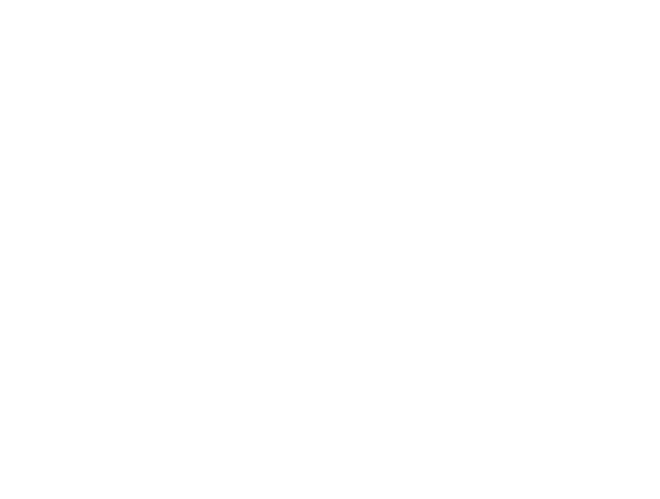

0it [00:00, ?it/s]

len(leftover_meshes_sig) = [<trimesh.Trimesh(vertices.shape=(2056, 3), faces.shape=(3349, 3))>]


  0%|          | 0/1 [00:00<?, ?it/s]

invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2055 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 33.09it/s]

Time for sk_meshparty_obj = 0.08242273330688477
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 117
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

widths = [6271.18431456]
width_median= 6271.184314564678
Time for correspondence = 0.18661880493164062
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/2 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.027176856994628906
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 11.426100254058838
Checking connected components after removing cycles
Total time for mesh KDTree = 0.022540569305419922
sbv[0].reshape(-1,3) = [[1468936.   574693.8 1112623. ]]
closest_sk_pt_coord BEFORE = [1467110.60911576  578567.92374513 1112556.22084362]
current_skeleton.shape = (118, 2, 3)
node_for_stitch = 3: [1467110.60911576  578567.92374513 1112556.22084362]
node_for_stitch AFTER = 3: [1467110.60911576  578567.92374513 1112556.22084362]
possible_node_loc = [  0 106 117]
possible_node_loc AFTER = [  0 106 117]
curr_shortest_path = [3, 1.0, 2.0, 4.0, 6.0, 0]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 1555.5275176598207
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1467110.60911576

  0%|          | 0/1 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (117, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 11.692030668258667
Working on limb correspondence for #0 MAP piece
xvfb-run -n 2568 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_94366.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_94366_remove_interior.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/remove_interior_76566.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_94366.off
removed temporary output file: /neurd_p

0it [00:00, ?it/s]

Total time for decomposition = 1.1889214515686035
mesh_correspondence_first_pass: 1.1889572143554688
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (117, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (117, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.3353239773066587
 conflict_indices % = 0.03254702896386981


  0%|          | 0/4 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 13.260716915130615
correspondence_1_to_1: 0.36464929580688477
Total time for MAP sublimb processing 13.260810852050781
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 13.577497959136963
Number of matching vertices = 90
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/3 [00:00<?, ?it/s]

3348 3349
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Successful Limb Decomposition
Total time for Skeletonization and Mesh Correspondence = 107.1283826828003


 ----- Working on Stitching ----------
Starting the floating pieces preprocessing
Floating 0: <trimesh.Trimesh(vertices.shape=(113, 3), faces.shape=(176, 3))>
invalidation_d = 12000
use_adaptive_invalidation_d= True
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 1000
invalidation_d = 12000
root_curr = None
Time for preparing soma vertices and root: 5.245208740234375e-06
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 68.54it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.03454256057739258
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 11
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

widths = [401.05045273]
width_median= 401.0504527276903
segment_widths_median = [401.05045273]
Decomposing first pass: 0.05188918113708496
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 3.504753112792969e-05
Total time for MAP sublimb processing 2.86102294921875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.9788742065429688e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 0.08762526512145996


  0%|          | 0/2 [00:00<?, ?it/s]

Removed 2 skeletal branches
There were no branches after cleaning limb correspondence


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 0.15139269828796387
Floating 1: <trimesh.Trimesh(vertices.shape=(75, 3), faces.shape=(140, 3))>
invalidation_d = 12000
use_adaptive_invalidation_d= True
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 1000
invalidation_d = 12000
root_curr = None
Time for preparing soma vertices and root: 1.239776611328125e-05
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 66.76it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.032060861587524414
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 24
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

widths = [160.00581375]
width_median= 160.0058137490787
segment_widths_median = [160.00581375]
Using the axon parameters
invalidation_d = 1500
smooth_neighborhood = 0
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 72.67it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.07539248466491699
branches_touching_root = [0]
combining close nodes
combine_threshold = 1300
length of Graph = 34
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

widths = [159.99537003]
width_median= 159.99537002709803
segment_widths_median = [159.99537003]
Using the axon parameters
Decomposing first pass: 0.0454251766204834
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 2.6226043701171875e-05
Total time for MAP sublimb processing 2.86102294921875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.9788742065429688e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 0.1549379825592041
Removed 0 skeletal branches


  0%|          | 0/1 [00:00<?, ?it/s]

139 140
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 0.2631189823150635
Total time for stitching floating pieces = 3.0093605518341064
Total time for Concept Networks = 1.9257118701934814
Total time for all mesh and skeletonization decomp = 112.06469917297363
No soma volume ratios so computing them now
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 9382 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_357763.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_357763_poisson.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_53182.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_357763.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/n

MAX ITERATIONS initially 500
AREA VARIATION initially 0.0001
medial centered initially 1
medially_centered_speed_tradeoff initially 0.2
quality_speed_tradeoff initially 0.1
max_triangle_angle initially 1.91986
min_edge_length initially 65.844
setting the edge length by absolute length
min_edge_length AFTER = 75
max_triangle_angle AFTER = 1.91986
quality_speed_tradeoff AFTER = 0.2
set_medially_centered_speed_tradeoff AFTER = 0.2
medial centered AFTER 1
AREA VARIATION AFTER 0.0001
MAX ITERATIONS AFTER 500
medial centered END 1
set_medially_centered_speed_tradeoff END = 0.2
quality_speed_tradeoff END = 0.2
Max iterations END = 500
AREA VARIATION END 0.0001
Number of vertices of the skeleton: 292
Number of edges of the skeleton: 291
MAX ITERATIONS initially 500
AREA VARIATION initially 0.0001
medial centered initially 1
medially_centered_speed_tradeoff initially 0.2
quality_speed_tradeoff initially 0.1
max_triangle_angle initially 1.91986
min_edge_length initially 25.9629
setting the edge 

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 102



  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 12



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 20



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 100



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 82



  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 7



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 8



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 184



  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 22



  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 2



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 36



  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 8



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 12



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 25



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 6



  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 152



  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 145



  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 14



  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 2



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 106



  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 54



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 30



  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 9



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 4



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 6



  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 80



  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 12



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 134



  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 120



  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 13



  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 19



  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Filtering away by face and skeletal length
width_name BEFORE processing = no_spine_median_mesh_center
After processing
width_name = no_spine_median_mesh_center, distance_by_mesh_center= True, no_spines = True, summary_measure= median
Working on limb L0 branch 6
    No spines and using precomputed width: 604.7316106610253
Working on limb L0 branch 3
    current_width= 422.01733213972807
Working on limb L0 branch 7
    No spines and using precomputed width: 345.98403683769595
Working on limb L0 branch 0
    current_width= 261.67118520971894
Working on limb L0 branch 1
    current_width= 272.5726579178621
Working on limb L0 branch 2
    current_width= 289.88795449575736
Working on limb L0 branch 4
    current_width= 301.21669775687826
Working on limb L0 branch 8
    No spines and using precomputed width: 306.9702914678095
Working on limb L0 branch 5
    current_width= 243.4878907921956
Working on limb L0 branch 9
    current_width= 279.4323342661673
Working on limb L1 branch 17
    curren

In [23]:
from neurd import neuron

neuron_obj = neuron.Neuron(
    mesh = mesh,
    segment_id = segment_id, # don't need this explicitely if segment_id is already in products
    pipeline_products = products,
    suppress_preprocessing_print=False,
    suppress_output=False,
)

neuron_obj

In [ ]:
nviz.visualize_neuron(
    neuron_obj,
    limb_branch_dict="all"
)

In [ ]:
nviz.visualize_neuron_limbs(neuron_obj)

In [ ]:
nviz.visualize_neuron_specific_limb(neuron_obj,"L2")

In [ ]:
ipvu.plot_objects(neuron_obj[2][0].mesh)

# Calculate statistics

In [24]:
_ = neuron_obj.calculate_decomposition_products(
    store_in_obj = True,
)

In [25]:
print(neuron_obj.pipeline_products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691135510518224,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>, <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>, <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>, <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>, <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>, <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>, <trimesh.Trimesh(vertices.shape=(864, 3), faces.shape=(1989, 3))>, <trimesh.Trimesh(vertices.shape=(723, 3), faces.shape=(1611, 3))>, <trimesh.Trimesh(vertices.shape=(693, 3), faces.shape=(1561, 3))>, <trimesh.Trimesh(vertices.shape=(612, 3), faces.shape=(1378, 3))>, <trimesh.Trimesh(vertices.shape=(456, 3), faces.shape=(742, 3))>, <trimesh.Trimesh(vertices.shape=(344, 3), faces.

# Saving off neuron

In [26]:
vdi.save_neuron_obj(
    neuron_obj,
    verbose = True
)

Total time for soma meshes compression = 0.17325329780578613
Total time for insignificant_limbs,inside_pieces,non_soma_touching_meshes,not_processed_soma_containing_meshes compression = 0.32379913330078125
Total time for limb_meshes compression = 0.5666310787200928
    Starting Limb Correspondence Compression


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Total time for new_limb_correspondence compression = 3.793098211288452
Cleared mesh: <trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>:139864068125984
Cleared mesh: <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>:139864068149360
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>:139864068152192
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>:139864067962576
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>:139864068151856
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>:139864068127328
Cleared mesh: <trimesh.Trimesh(vertices.shape=(864, 3), faces.shape=(1989, 3))>:139863558710368
Cleared mesh: <trimesh.Trimesh(vertices.shape=(723, 3), faces.shape=(1611, 3))>:139863558684976
Cleared mesh: <trimesh.Trimesh(vertices.shape=(693, 3), faces.shape=(1561, 3))>:139864067961808
Cleared mesh: <trimesh.Trimesh(vertices.shape=(612, 3), fa

'864691135510518224.pbz2'

In [29]:
nviz.visualize_neuron(neuron_obj,limb_branch_dict="all")


 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [30]:
ipvu.plot_objects(neuron_obj.mesh)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

# Reloading the Neuron

In [ ]:
neuron_obj = vdi.load_neuron_obj(
    segment_id = segment_id,
    #mesh_decimated = mesh_decimated
)

In [ ]:
print(neuron_obj.pipeline_products)

# Step 4A: Multi Soma Split Suggestions

In [ ]:
from neurd import neuron_visualizations as nviz
nviz.plot_soma_limb_concept_network(
    neuron_obj
)

In [ ]:
multi_soma_split_parameters = dict()

In [ ]:
_ = neuron_obj.calculate_multi_soma_split_suggestions(
    plot = True,
    store_in_obj = True,
    **multi_soma_split_parameters
)


In [ ]:
neuron_obj.pipeline_products.multi_soma_split_suggestions.multi_soma_split_parameters = multi_soma_split_parameters

# Step 4B: Multi Soma Split Execution

In [ ]:
neuron_list = neuron_obj.multi_soma_split_execution(
    verbose = False,
)

In [ ]:
ipvu.plot_objects(
    meshes = [
        neuron_list[0].mesh_from_branches,
        neuron_list[1].mesh_from_branches,
    ],
    meshes_colors=["red","blue"]
)

In [ ]:
n1 = neuron_list[0]
print(n1.pipeline_products)

# Step 4b: Saving Split Neurons

In [ ]:
vdi.save_neuron_obj(
    n1,
    suffix = "_split_0",
)

# Step 4c: Decompressing Split Neuron

In [ ]:
from neurd import neuron_utils as nru

neuron_obj_path = Path(f"./{segment_id}_split_0.pbz2")
neuron_obj_path.exists()

n1 = nru.decompress_neuron(
    filepath = neuron_obj_path,
    original_mesh = mesh, 
    suppress_output = False
)

# Step 5: Cell Typing

In [ ]:
from neurd import neuron_pipeline_utils as npu

In [ ]:
neuron_obj_axon = npu.cell_type_ax_dendr_stage(
    n1,
    mesh_decimated = mesh_decimated,
    plot_axon = False,
)

In [ ]:
nviz.plot_axon(
    neuron_obj_axon
)

# Autoproofreading Stage

In [ ]:
neuron_obj_proof = npu.auto_proof_stage(
    neuron_obj_axon,
    mesh_decimated = mesh_decimated,
    calculate_after_proof_stats = False,
)

In [ ]:
_ = npu.after_auto_proof_stats(
    neuron_obj_proof,
    store_in_obj = True,
)

# Saving off the autoproofread neuron

In [ ]:
vdi.save_neuron_obj_auto_proof(
    neuron_obj_proof,
)

# Plotting the final neuron

In [ ]:
from neurd import synapse_utils as syu

In [ ]:
from datasci_tools import ipyvolume_utils as ipvu
ipvu.plot_objects(
    neuron_obj_axon.mesh,
    meshes = [neuron_obj_proof.mesh],
    meshes_colors="red"
)

In [ ]:
syu.plot_synapses(neuron_obj_proof)

In [ ]:
syu.plot_synapses_error_from_neuron_obj(neuron_obj_proof)    

In [ ]:
syu.plot_synapses_valid_from_neuron_obj(neuron_obj_proof)  

In [ ]:
nviz.plot_compartments(neuron_obj_proof)